In [1]:
cd submodules/network_diffusion/

C:\Users\DSERWATA\Priv\_phd\workspace\bdma-experiments\submodules\network_diffusion


In [2]:
import network_diffusion as nd
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm
from utils import functions, models, networks

%load_ext autoreload
%autoreload 2

In [3]:
functions.set_seed(42)

# the path to events
dataset_name = 'manufacturing-sample'
path_events = "network_diffusion/tests/data/" + dataset_name + ".csv"
delimiter = ";"

# as per the initial CogSNet paper ("Social Networks through the Prism of Cognition")
# these parameters performed relatively well
forgetting_type = "exponential"
snapshot_interval = 24
edge_lifetime = 7
mu = 0.8
theta = 0.1
units = 3600

In [4]:
temporal_network = nd.TemporalNetwork.from_cogsnet(
            forgetting_type,
            snapshot_interval,
            edge_lifetime,
            mu,
            theta,
            units,
            path_events,
            delimiter)
temporal_network = functions.preprocess_temporal_network(temporal_network, theta)

static_network = functions.create_static_network(path_events, delimiter)
static_network = nd.TemporalNetwork.from_nx_layers(55 * [static_network])

In [5]:
N_REPETITIONS = 100

seeding_budget_active = [1, 5, 15, 25, 50]
mi_values = [0.05, 0.1, 0.15, 0.20, 0.25, 0.50]

results = []
for seeding_budget in seeding_budget_active:
    for mi in mi_values:
        results_temporal = []
        results_static = []
        for i in tqdm(range(N_REPETITIONS)):
            mltm = nd.models.MLTModel(
                protocol="AND",
                seed_selector=nd.seeding.RandomSeedSelector(),
                seeding_budget=(100-seeding_budget, seeding_budget),
                mi_value=mi,
            )

            # define simulators for temporal (CogSNet) and static networks (where static has huge edge lifetime)
            experiment_temporal = nd.Simulator(model=mltm, network=temporal_network)
            experiment_static = nd.Simulator(model=mltm, network=static_network)

            # run the experiments
            result_cogsnet = experiment_temporal.perform_propagation(n_epochs=54, patience=1)
            results_temporal.append(result_cogsnet)
            result_static = experiment_static.perform_propagation(n_epochs=54, patience=1)
            results_static.append(result_static)

        epochs, start_0, start_1, final_0, final_1 = functions.get_metrics(results_temporal)
        results.append([dataset_name, 'Temporal', mi, seeding_budget, epochs, start_0, start_1, final_0, final_1])

        epochs, start_0, start_1, final_0, final_1 = functions.get_metrics(results_static)
        results.append([dataset_name, 'Static', mi, seeding_budget, epochs, start_0, start_1, final_0, final_1])

        with open('../../mltm_cogsnet/results/' + dataset_name + '-CogSNet-' + str(mi) + '-' + str(seeding_budget) + '.pickle', 'wb') as results_temporal_file:
            pickle.dump(results_temporal, results_temporal_file)

        with open('../../mltm_cogsnet/results/' + dataset_name + '-Static-' + str(mi) + '-' + str(seeding_budget) + '.pickle', 'wb') as results_static_file:
            pickle.dump(results_static, results_static_file)
                
results_df = pd.DataFrame(results, columns=['dataset', 'method', 'mi', 'budget', 'epochs', 'start_0', 'start_1', 'final_0', 'final_1'])
results_df.to_csv('../../mltm_cogsnet/results/experiment_results.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


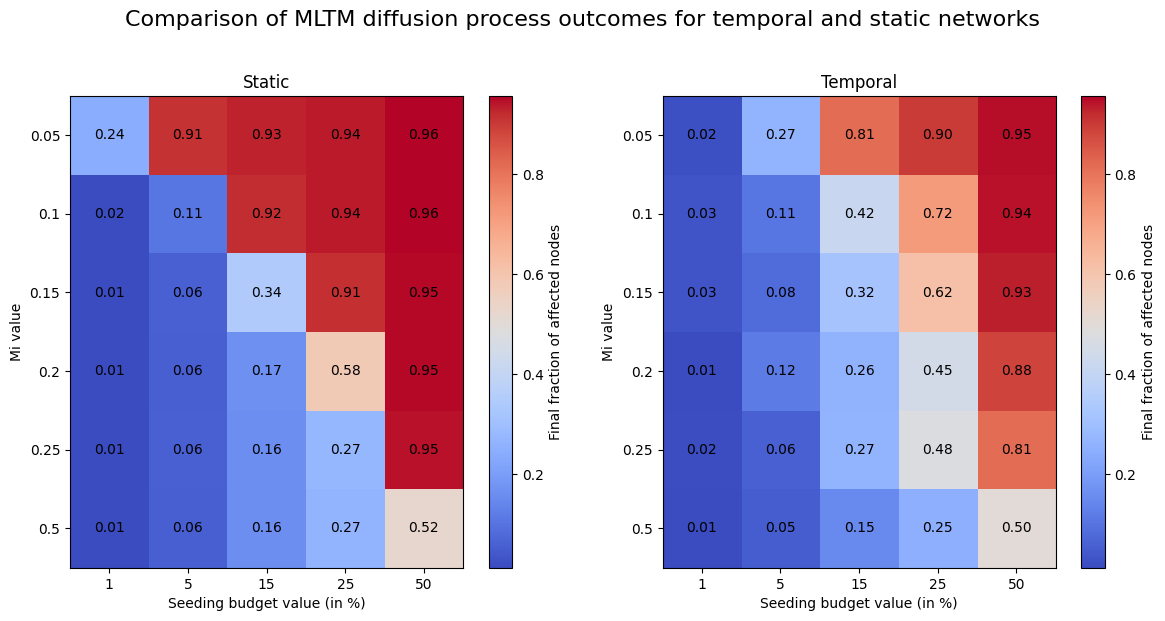

In [6]:
functions.visualize_results_as_heatmap(
    results_df,
    index='mi',
    columns='budget',
    values='final_1',
    title='Comparison of MLTM diffusion process outcomes for temporal and static networks',
    colorbar_label='Final fraction of affected nodes',
    x_label='Seeding budget value (in %)',
    y_label='Mi value'
)